In [2]:
import os
import os.path
import sys
import h5py
import numpy as np
import scipy.io as scio
from keras.models import Model, Sequential
from keras.layers import *
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import normalize
import random
import matplotlib.pyplot as plt

#AES SBox lookup table 
AES_Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

#AES Inverse SBox lookup table
Inv_SBox = np.array([
    0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3,
    0x9e, 0x81, 0xf3, 0xd7, 0xfb , 0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f,
    0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb , 0x54,
    0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b,
    0x42, 0xfa, 0xc3, 0x4e , 0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24,
    0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25 , 0x72, 0xf8,
    0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d,
    0x65, 0xb6, 0x92 , 0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda,
    0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84 , 0x90, 0xd8, 0xab,
    0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3,
    0x45, 0x06 , 0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1,
    0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b , 0x3a, 0x91, 0x11, 0x41,
    0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6,
    0x73 , 0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9,
    0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e , 0x47, 0xf1, 0x1a, 0x71, 0x1d,
    0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b ,
    0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0,
    0xfe, 0x78, 0xcd, 0x5a, 0xf4 , 0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07,
    0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f , 0x60,
    0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f,
    0x93, 0xc9, 0x9c, 0xef , 0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5,
    0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61 , 0x17, 0x2b,
    0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55,
    0x21, 0x0c, 0x7d
])

Using TensorFlow backend.


In [4]:
def check_file_exists(file_path):
    file_path = os.path.normpath(file_path)
    if os.path.exists(file_path) == False:
        print("Error: provided file path '%s' does not exist!" % file_path)
        sys.exit(-1)
    return

In [5]:
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

In [6]:
def mlp_design(classes=256):  


    model = Sequential()
	
    model.add(Dense(200, input_dim=20, activation='relu'))  #input_dim=5  all are 100 nodes before

    model.add(Dense(400, activation='relu'))
    model.add(Dense(classes, activation='softmax'))	
    optimizer = RMSprop(lr=0.0001)   
	
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	

	
    return model

In [7]:
def conv_autoencoder_design(num_samples=20):
    #encoder
    model = Sequential()

    model.add(Conv1D(input_shape=(20, 1) , filters=4, kernel_size=4, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2))  

    model.add(Conv1D( filters=8, kernel_size=4, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2)) 

    #decoder  
    model.add(Conv1D( filters=8, kernel_size=4, activation='relu', padding='same'))	  

    model.add(UpSampling1D(2))  
    model.add(Conv1D( filters=4, kernel_size=4, activation='relu', padding='same'))	
    #model.add(AveragePooling1D(pool_size=2,strides=1)) 
    
    model.add(UpSampling1D(2))  
    model.add(Conv1D(1, 3, activation='relu', padding='same', name='output_conv'))	
    
    optimizer = RMSprop(learning_rate=0.00005)  
    
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [8]:
def conv_autoencoder_dense_design(num_samples=20):
    #encoder
    model = Sequential()

    model.add(Conv1D(input_shape=(20, 1) , filters=4, kernel_size=4, activation='selu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2))  

    model.add(Conv1D( filters=8, kernel_size=4, activation='selu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2)) 

   # model.add(Conv1D( filters=16, kernel_size=4, activation='selu', padding='same'))	
   # model.add(AveragePooling1D(pool_size=2))    
    
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='selu'))
    model.add(Dense(40, activation='selu'))
    model.add(Reshape((5, 8)))
    #decoder  
    model.add(Conv1D( filters=8, kernel_size=4, activation='selu', padding='same'))	  

    model.add(UpSampling1D(2))  
    model.add(Conv1D( filters=4, kernel_size=4, activation='selu', padding='same'))	
    #model.add(AveragePooling1D(pool_size=2,strides=1)) 
    
    model.add(UpSampling1D(2))  
    model.add(Conv1D(1, 3, activation='selu', padding='same', name='output_conv'))	
    
    optimizer = RMSprop(lr=0.00005)  
    
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [9]:
def cnn_design(classes=256):  

       
    model = Sequential()
    model.add(Conv1D(input_shape=(110, 1) , filters=4, kernel_size=3, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2,strides=1))   	
	
    model.add(Conv1D( filters=8, kernel_size=3, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2,strides=1)) 

    model.add(Conv1D( filters=16, kernel_size=3, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2,strides=1)) 	

    model.add(Conv1D( filters=32, kernel_size=3, activation='relu', padding='same'))	
    model.add(AveragePooling1D(pool_size=2,strides=1)) 
	
    model.add(Flatten())
	
    #model.add(Dropout(0.2))
	
    model.add(Dense(units = 200, activation = 'relu'))
    model.add(Dense(units = 200, activation = 'relu'))
	
    model.add(Dense(units = classes, activation = 'softmax',name='predictions'))	
    optimizer = RMSprop(lr=0.00005) #0.0001
	
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])	
    

	
    return model

In [10]:
def rnn_design(classes=256):
    model = Sequential()
    model.add(SimpleRNN(60, return_sequences=True, input_shape=[50, 1]))
    model.add(SimpleRNN(60))
    model.add(Dense(units = 200, activation = 'relu'))
    model.add(Dense(units = 300, activation = 'relu'))
    model.add(Dense(classes, activation='softmax'))
    optimizer = RMSprop(learning_rate=0.0001) 
	
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [11]:

def lstm_design(classes=256):
    model = Sequential()
    model.add(LSTM(60,input_shape=(50, 1),return_sequences=True ))
    model.add(LSTM(60))
    #model.add(Dense(units = 200, activation = 'relu'))
    model.add(Dense(units = 300, activation = 'relu'))
    model.add(Dense(classes, activation='softmax'))
    optimizer = RMSprop(learning_rate=0.0001) 
	
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [12]:
def autoencoder_design(num_samples=20):
    #encoder
    model = Sequential()

    model.add(Dense(20, input_dim=num_samples, activation='relu')) 
    model.add(Dense(50, activation='relu'))
    model.add(Dense(100, activation='relu'))    


    #decoder
    model.add(Dense(50, activation='relu'))	
    model.add(Dense(20, activation='relu'))
    model.add(Dense(num_samples, activation='relu'))	
    optimizer = RMSprop(learning_rate=0.0001)  
    
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [13]:
def train_model(X_profiling, Y_profiling, model, save_file_name, epochs, batch_size, model_type):
    check_file_exists(os.path.dirname(save_file_name))
    # Save model every epoch
    save_model = ModelCheckpoint(save_file_name)
    callbacks = [save_model]
    # Get the input layer shape
    input_layer_shape = model.get_layer(index=0).input_shape
    # Sanity check
    if input_layer_shape[1] != len(X_profiling[0]):
        print("Error: model input shape %d instead of %d is not expected ..." % (
            input_layer_shape[1], len(X_profiling[0])))
        sys.exit(-1)
    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        Reshaped_X_profiling = X_profiling
        Reshaped_Y_profiling = to_categorical(Y_profiling, num_classes=256)
    elif len(input_layer_shape) == 3:
        # This is a CNN: expand the dimensions
        Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
        Reshaped_Y_profiling = to_categorical(Y_profiling, num_classes=256)
        if model_type ==6:
            Reshaped_Y_profiling = Y_profiling.reshape((Y_profiling.shape[0], Y_profiling.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)

    history = model.fit(x=Reshaped_X_profiling, y=Reshaped_Y_profiling, batch_size=batch_size, verbose=1, epochs=epochs, callbacks=callbacks, validation_split=0.1)
    return history

In [18]:
if __name__ == "__main__":

    model_type=2         #1 mlp, 2 cnn, 3 rnn, 4 lstm, 5 autoencoder, 6 conv autoencoder
    interest_byte=0

    Traces = np.load('data/old/nor_traces_with_noise_sigma0.0065.npy')
    #Traces = Traces[:,[i for i in range(130,240)]]   #the 110 points related to the sbox operation (first round)
    Traces = Traces[:,[i for i in range(200,310)]]    #the 110 points related to the sbox operation (last round)
    ct = np.load('data/old/ct.npy')
    key=np.load('data/old/lastroundkey.npy')
    key= key.astype(int)
    #print(key[:,interest_byte].shape)
    lastround_sboxout= np.bitwise_xor(ct[:,interest_byte],key[:,interest_byte])
    #lastround_input= Inv_SBox[lastround_sboxout]  
    labels=lastround_sboxout
    
    
    Traces_0m =Traces[:200000,:]
    Traces_15m=Traces[200000:,:]
    labels_0m =labels[:200000]
    labels_15m=labels[200000:]    
    
    NUMBER=50
    select = random.sample(range(len(Traces_15m)), NUMBER)
    
    
    Traces = np.concatenate((Traces_0m,Traces_15m[select,:]),axis=0)
    labels = np.concatenate((labels_0m,labels_15m[select]),axis=0)        
    
    
    
    if model_type==1:
        model_folder = 'mlp_model/'
        model = mlp_design()
    elif model_type==2:
        model_folder = 'cnn_model_old_noise0065/'
        model = cnn_design()
    elif model_type==3:
        model_folder = 'rnn_model/'
        model = rnn_design()
    elif model_type==4:
        model_folder = 'lstm_model/'
        model = lstm_design()
    elif model_type==5:
        labels = np.load('decoder/nor_traces_maxmin_decoder.npy')
        labels = labels[:,[i for i in range(200,220)]]
        model_folder = 'ae_model/'
        model = autoencoder_design()
    elif model_type==6:
        labels = np.load('decoder/nor_traces_maxmin_decoder.npy')
        labels = labels[:,[i for i in range(200,220)]]
        model_folder = 'ae_model/'
        model = conv_autoencoder_dense_design()
    else:
        print("Error: wrong model type")
        sys.exit(-1)
        
    print(model.summary())
    training_model = model_folder + 'cnn_model-{epoch:01d}.h5'
    #training_model = model_folder + 'model.h5'


    epochs = 100
    batch_size = 256
    ### training

    history_log = train_model(Traces, labels, model, training_model, epochs, batch_size, model_type)
    #print(history_log.history['val_accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 110, 4)            16        
_________________________________________________________________
average_pooling1d_9 (Average (None, 109, 4)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 109, 8)            104       
_________________________________________________________________
average_pooling1d_10 (Averag (None, 108, 8)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 108, 16)           400       
_________________________________________________________________
average_pooling1d_11 (Averag (None, 107, 16)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 107, 32)          

180045/180045 [==============================] - 24s 131us/step - loss: 5.1976 - accuracy: 0.0101 - val_loss: 5.1611 - val_accuracy: 0.0105
Epoch 42/100
180045/180045 [==============================] - 24s 135us/step - loss: 5.1960 - accuracy: 0.0100 - val_loss: 5.1941 - val_accuracy: 0.0102
Epoch 43/100
180045/180045 [==============================] - 25s 136us/step - loss: 5.1943 - accuracy: 0.0096 - val_loss: 5.1703 - val_accuracy: 0.0097
Epoch 44/100
180045/180045 [==============================] - 24s 135us/step - loss: 5.1928 - accuracy: 0.0105 - val_loss: 5.1637 - val_accuracy: 0.0124
Epoch 45/100
180045/180045 [==============================] - 24s 131us/step - loss: 5.1910 - accuracy: 0.0101 - val_loss: 5.1820 - val_accuracy: 0.0116
Epoch 46/100
180045/180045 [==============================] - 24s 132us/step - loss: 5.1895 - accuracy: 0.0101 - val_loss: 5.1697 - val_accuracy: 0.0103
Epoch 47/100
180045/180045 [==============================] - 24s 132us/step - loss: 5.1879 - a

180045/180045 [==============================] - 23s 129us/step - loss: 5.1304 - accuracy: 0.0118 - val_loss: 5.1341 - val_accuracy: 0.0111
Epoch 95/100
180045/180045 [==============================] - 23s 129us/step - loss: 5.1295 - accuracy: 0.0119 - val_loss: 5.1298 - val_accuracy: 0.0129
Epoch 96/100
180045/180045 [==============================] - 23s 130us/step - loss: 5.1291 - accuracy: 0.0116 - val_loss: 5.1074 - val_accuracy: 0.0122
Epoch 97/100
180045/180045 [==============================] - 23s 129us/step - loss: 5.1286 - accuracy: 0.0113 - val_loss: 5.1359 - val_accuracy: 0.0112
Epoch 98/100
180045/180045 [==============================] - 24s 132us/step - loss: 5.1277 - accuracy: 0.0117 - val_loss: 5.1135 - val_accuracy: 0.0109
Epoch 99/100
180045/180045 [==============================] - 24s 132us/step - loss: 5.1271 - accuracy: 0.0115 - val_loss: 5.1175 - val_accuracy: 0.0118
Epoch 100/100
180045/180045 [==============================] - 23s 130us/step - loss: 5.1261 - 

In [ ]:
model_type=2         #1 mlp, 2 cnn, 3 rnn, 4 lstm, 5 autoencoder, 6 conv autoencoder
interest_byte=0

Traces = np.load('data/nor_traces_maxmin.npy')
#Traces = Traces[:,[i for i in range(130,240)]]   #the 110 points related to the sbox operation (first round)
Traces = Traces[:,[i for i in range(200,220)]]    #the 110 points related to the sbox operation (last round)
ct = np.load('data/ct.npy')
key=np.load('data/lastroundkey.npy')
key= key.astype(int)
#print(key[:,interest_byte].shape)
lastround_sboxout= np.bitwise_xor(ct[:,interest_byte],key[:,interest_byte])
#lastround_input= Inv_SBox[lastround_sboxout]  
labels=lastround_sboxout

x=np.arange(0,255,1)
print(labels[:5000].shape)
num_bins = 256
plt.hist(labels[:100000],bins = 256)
plt.xlim([0,255])
plt.xlabel('Fisrt-round Sbox output values')
plt.ylabel('Number of occurrences in 100K traces')
plt.savefig('last_round_label_uniformity_100k.png',dpi=500)

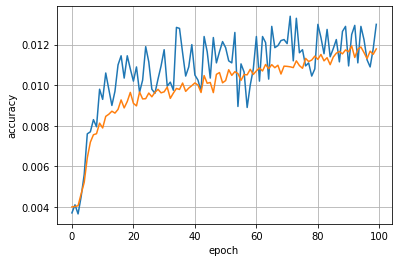

In [19]:
plt.plot(history_log.history['val_accuracy'])
plt.plot(history_log.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.savefig("acc_cnn_model_old_noise_0.0065.png",dpi=500)
plt.show()

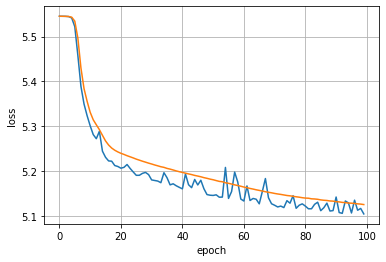

In [20]:
plt.plot(history_log.history['val_loss'])
plt.plot(history_log.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.savefig("loss_cnn_model_old_noise_0.0065.png",dpi=500)
plt.show()

In [2]:
Traces = np.load('data/nor_traces_maxmin_processed.npy')
#Traces = Traces[:,[i for i in range(209,229)]]
ct = np.load('data/ct.npy')
key=np.load('data/lastroundkey.npy')

In [4]:
key[0]

array([  0., 133., 246., 188., 164.,  31.,  59., 238., 234., 141., 114.,
       219., 146.,  98., 116., 239.])

In [5]:
Traces[0] 

array([0.68285364, 0.6130295 , 0.37469494, 0.7206424 , 0.93432   ,
       0.4677796 , 0.10319898, 0.3457454 , 0.6359671 , 0.52670234,
       0.4899326 , 0.38820153, 0.09933071, 0.44716015, 0.65536493,
       0.47494447, 0.52860117, 0.28258523, 0.1491577 , 0.516678  ],
      dtype=float32)

In [5]:
Traces = np.load('data/nor_traces_maxmin.npy')
Traces = Traces[:,[i for i in range(130,240)]]   #the 110 points related to the sbox operation (last round)
#Traces = Traces[:,[i for i in range(200,310)]]    #the 110 points related to the sbox operation (first round)
Traces_2 = np.load('data/lastround_trace/nor_traces_maxmin.npy')
Traces_2 = Traces[:,[i for i in range(130,240)]]   #the 110 points related to the sbox operation (last round)
#Traces = Traces[:,[i for i in range(200,310)]]    #the 110 points related to the sbox operation (first round)
plt.plot(Traces[0])
plt.plot(Traces_2[0])

FileNotFoundError: [Errno 2] No such file or directory: 'data/lastround_trace/nor_traces_maxmin.npy'

KeyError: 'val_accuracy'